# 信用情報の学習
## 1. このテキストについて
### テキストの目的
実データに近いものに対して機械学習を行う

### どのように学ぶか
Kaggleのデータセットを通じて、機械学習の基本的な流れやライブラリの使い方を学びます。

## 2.信用情報
Kaggleの Home Credit Default Risk コンペティションの学習および推定を行います。

・Home Credit Default Risk | Kaggle

# 【問題1】コンペティション内容の確認
コンペティションのOverviewページ読み、「Home Credit Default Risk」について以下の観点について確認してください。

・何を学習し、何を予測するのか\
・どのようなファイルを作りKaggleに提出するか\
・提出されたものはどういった指標値で評価されるのか

In [1]:
print("・何を学習し、何を予測するのか？")
print("　過去のローン申請データを使って、申請者がローンを返済できるかどうかを予測する")
print("")
print("・どのようなファイルを作りKaggleに提出するか？")
print("  テストセットの各SK_ID_CURRに対して、TARGET変数の確率を予測する")
print("")
print("・提出されたものはどういった指標値で評価されるのか？")
print("　予測した確率と観測したTargetの間のROC曲線下の面積で評価される")

・何を学習し、何を予測するのか？
　過去のローン申請データを使って、申請者がローンを返済できるかどうかを予測する

・どのようなファイルを作りKaggleに提出するか？
  テストセットの各SK_ID_CURRに対して、TARGET変数の確率を予測する

・提出されたものはどういった指標値で評価されるのか？
　予測した確率と観測したTargetの間のROC曲線下の面積で評価される


## 3.ベースラインモデルの作成
まずは単純な方法によるベースラインモデルを作成します。精度の基準となるモデルです。\
精度を高くする必要はありません。エラーなく実行でき、Kaggle側に推定値を提出できることを目指します。

# 【問題2】学習と検証・・・（【問題4】も含む）
データを簡単に分析、前処理し、学習、検証するまでの一連の流れを作成・実行してください。\
検証にはこのコンペティションで使用される評価指標を用いるようにしてください。\
学習に用いる手法は指定しません。



In [2]:
# 基本的なモジュールをインポートします。
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [3]:
# データセットを読み込みます。
application_test = pd.read_csv('application_test.csv')
application_train = pd.read_csv('./application_train.csv')
# bureau = pd.read_csv('./bureau.csv')  かなり重たくなってしまったので割愛
# bureau_balance = pd.read_csv('./bureau_balance.csv')　かなり重たくなってしまったので割愛
credit_card_balance = pd.read_csv('./credit_card_balance.csv')
# installments_payments = pd.read_csv('./installments_payments.csv')　 かなり重たくなってしまったので割愛
# POS_CASH_balance = pd.read_csv('./POS_CASH_balance.csv') かなり重たくなってしまったので割愛
previous_application = pd.read_csv('./previous_application.csv')
HomeCredit_columns_description = pd.read_csv('./HomeCredit_columns_description.csv',encoding="Windows-1252")

In [4]:
#　読み込めないCSVのエンコードの確認の仕方。
from chardet import detect  # chardetパッケージからdetect関数をインポート

with open('HomeCredit_columns_description.csv', 'rb') as f:  # バイナリファイルとして読み込みオープン
    b = f.read()  # ファイルから全データを読み込み
    enc = detect(b)  # 読み込んだデータdetect関数に渡して判定する

print(enc)

{'encoding': 'Windows-1252', 'confidence': 0.73, 'language': ''}


In [5]:
# データを統合します。
df = pd.concat([application_train, application_test], ignore_index = True)

# 提出用にapplication_testのSK_ID_CURRを準備します。
SK_ID_CURR = application_test['SK_ID_CURR']

In [6]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1.0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0.0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0.0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0.0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0.0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


### 確認

まずは問題の目的を確認する。\
この問題の目的はapplication_testのSK_ID_CURRに対して、TARGETを推定すること。\
TARGETには「0」か「1」が入り、「0」はローンが期限内に返済されたことを示し、「1」は顧客が支払い困難であったことを示す。\
TARGETが目的変数で、それ以外が説明変数である。

### 分析

In [7]:
# まずは、基本情報を確認する。
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356255 entries, 0 to 356254
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(66), int64(40), object(16)
memory usage: 331.6+ MB


356255行122列あり、各列のデータはfloat、int、objectになる。

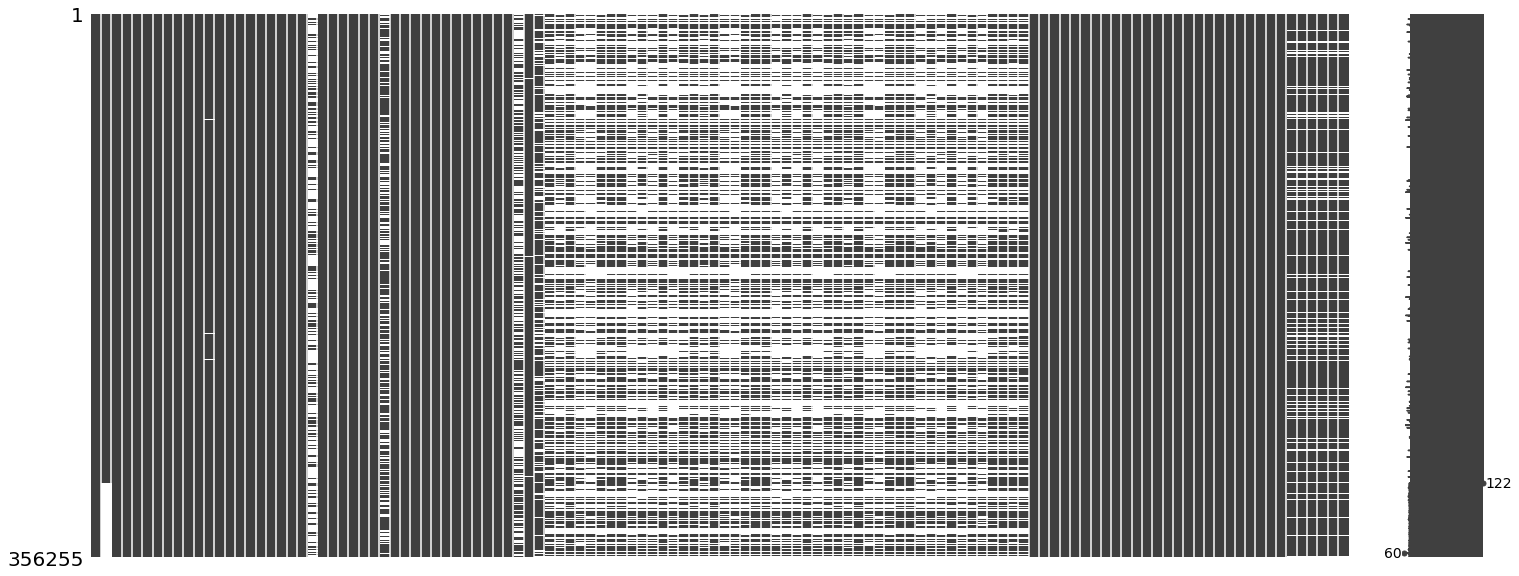

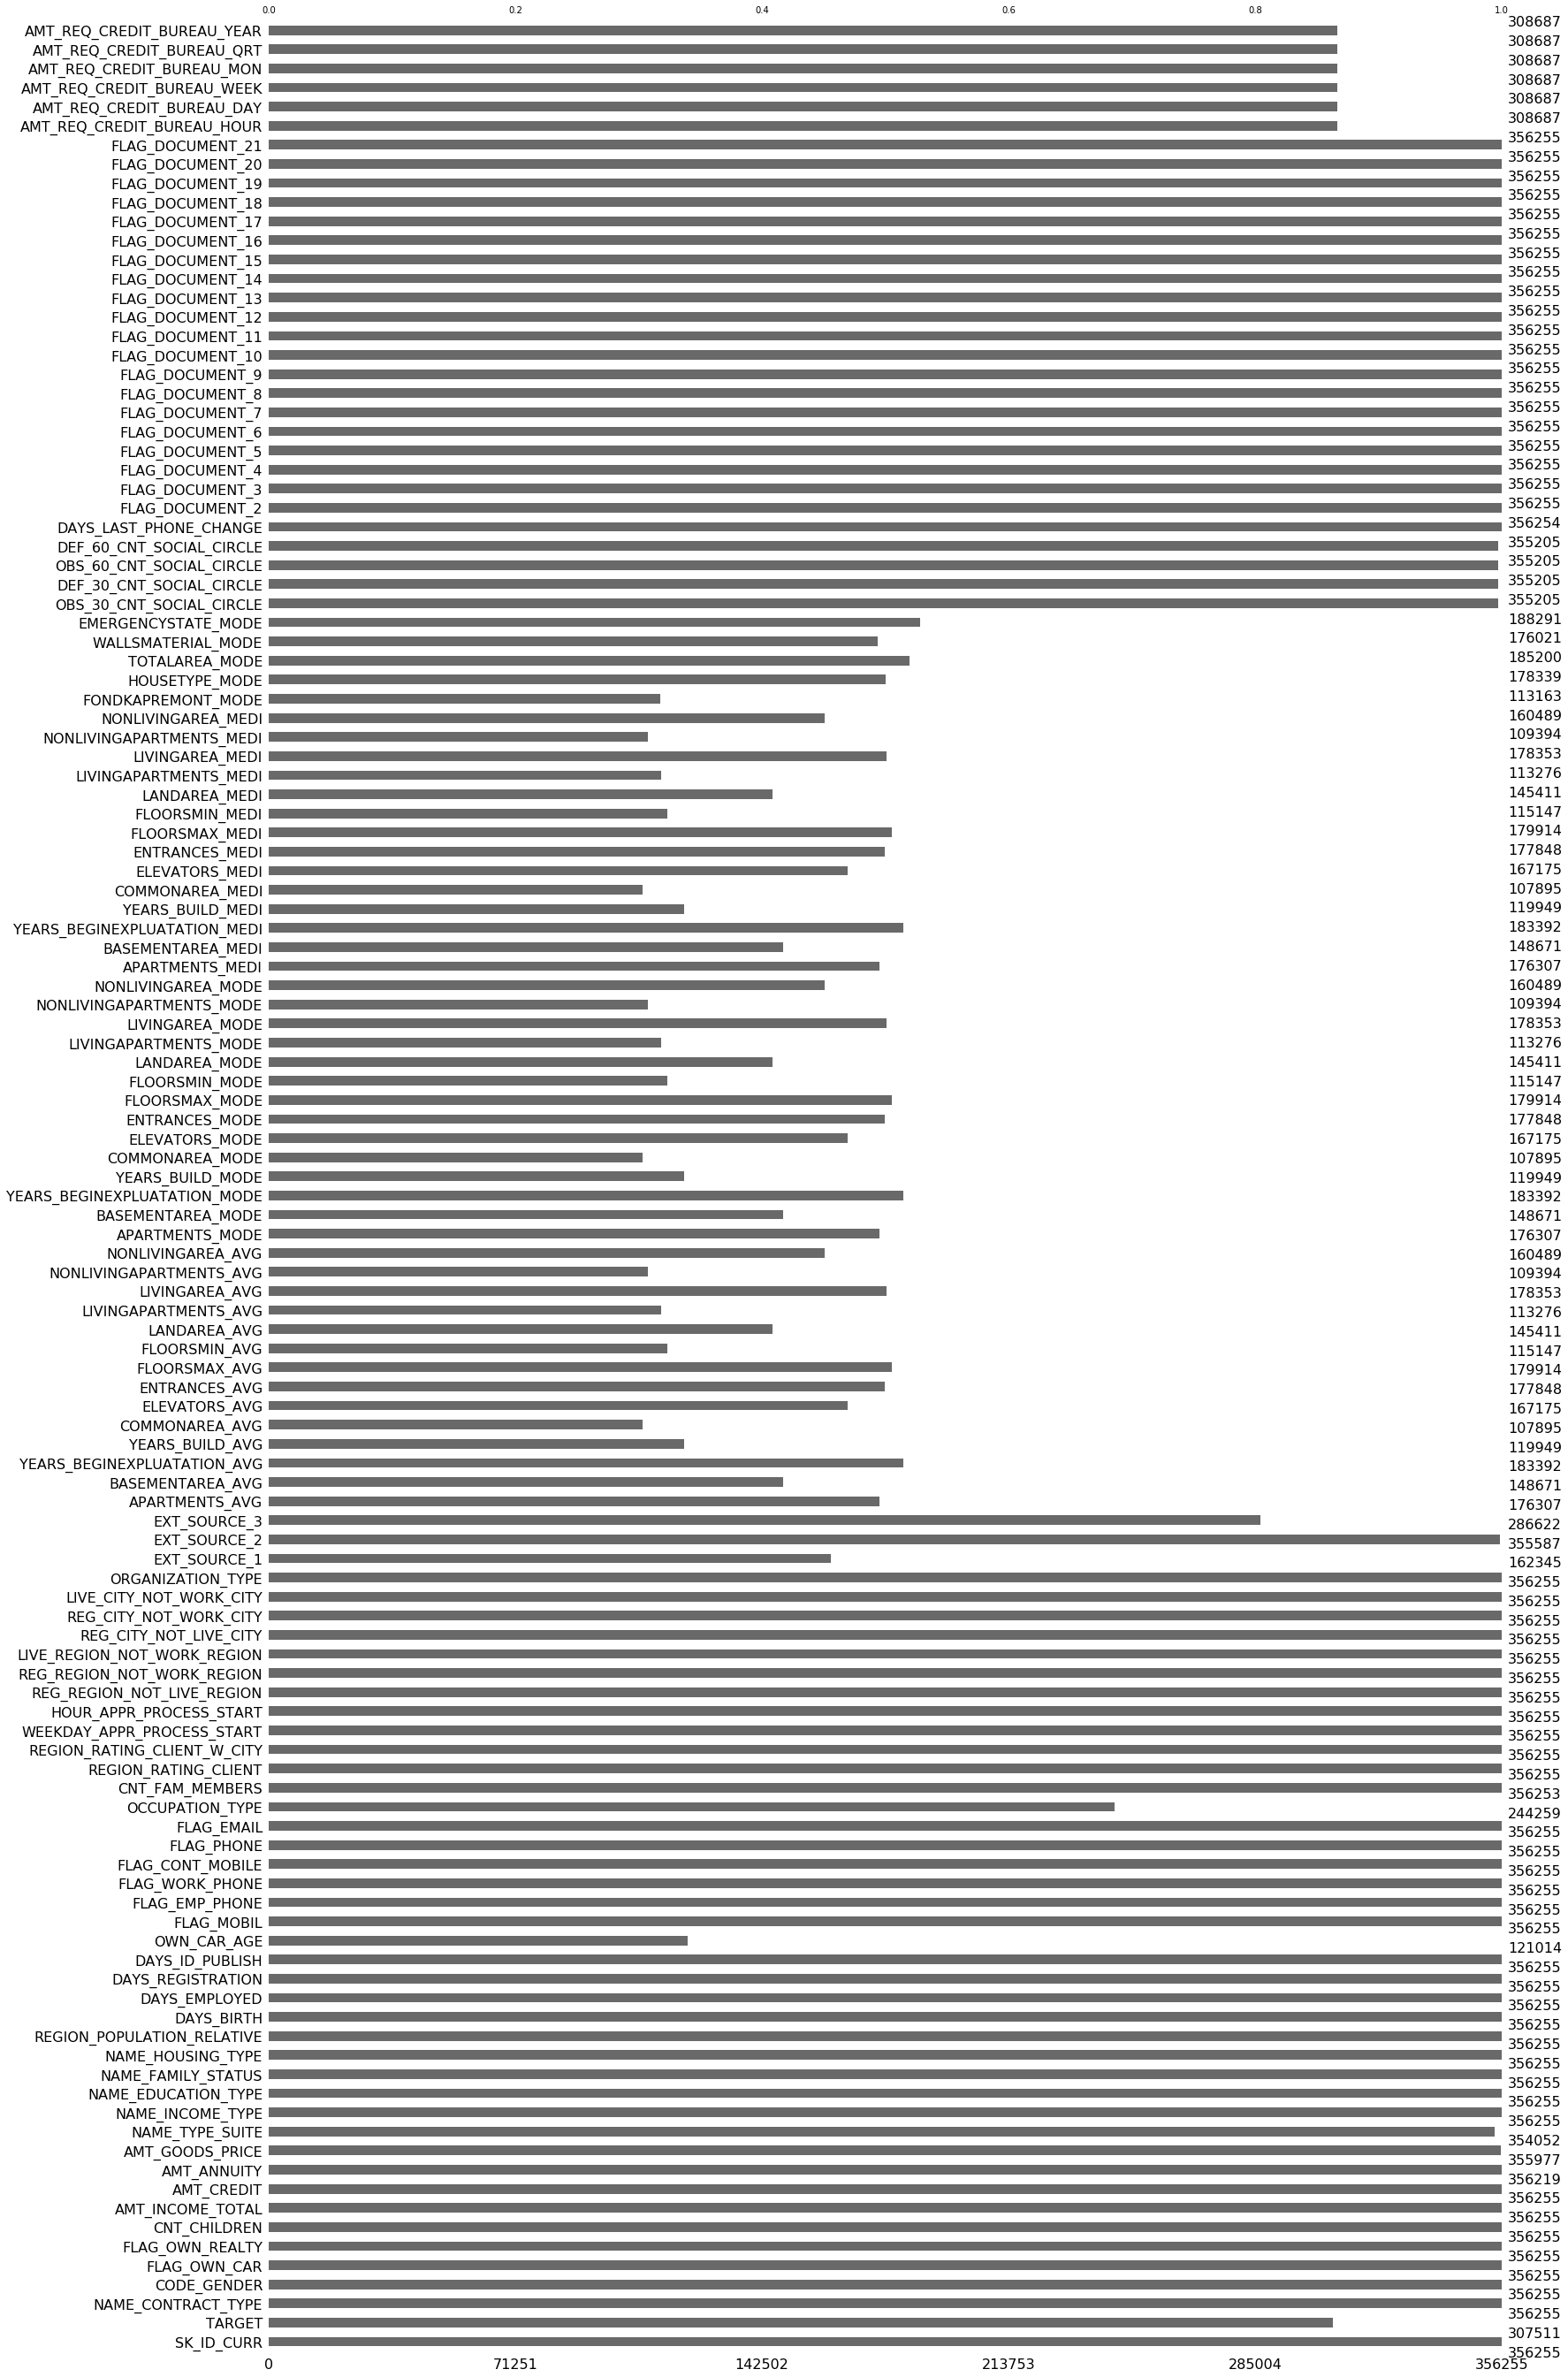

In [8]:
# 欠損値の状況を確認します。
display(msno.matrix(df))
plt.show()
display(msno.bar(df))
plt.show()

欠損値が多く含まれていることが分かる。

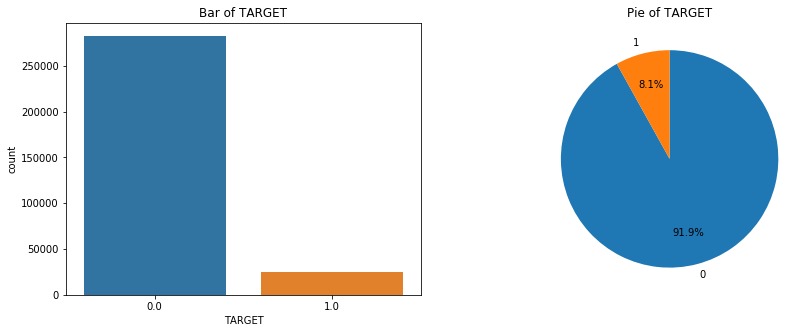

In [9]:
# 目的変数(TARGET)の分布をみる。
# TARGETの棒グラフ
plt.subplots(1, 2, figsize=(14,5))
plt.subplot(1,2,1)
plt.title("Bar of TARGET")
sns.countplot(x='TARGET', data=df)

# TARGETの円グラフ
plt.subplot(1,2,2)
plt.title("Pie of TARGET")
label=["0", "1"]
plt.pie(df['TARGET'].value_counts(),
       labels=label, counterclock=False, startangle=90,
       autopct='%1.1f%%', pctdistance=0.7)
plt.show()

91.9%が期限内に返済できており、8.1%が出来ていない。

他のファイルの中身を確認する。

In [10]:
credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [11]:
previous_application.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
HomeCredit_columns_description.head()

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN


In [13]:
credit_card_balance_sum = credit_card_balance.groupby('SK_ID_CURR').sum()
previous_application_sum = previous_application.groupby('SK_ID_CURR').sum()

In [14]:
credit_card_balance_sum.head()

,SK_ID_PREV,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,...,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100006,8936376,-21,0.000,1620000,0.0,0.0,0.0,0.0,0.000,0.00,...,0.000,0.000,0.000,0.0,0,0.0,0.0,0.0,0,0
100011,136410416,-2849,4031676.225,12150000,180000.0,180000.0,0.0,0.0,288804.195,358386.75,...,3877754.580,4028055.255,4028055.255,4.0,4,0.0,0.0,1881.0,0,0
100013,195714432,-4656,1743352.245,12645000,571500.0,571500.0,0.0,0.0,129454.020,688161.24,...,1656533.745,1737703.665,1737703.665,23.0,23,0.0,0.0,1666.0,1,1
100021,44098425,-170,0.000,11475000,0.0,0.0,0.0,0.0,0.000,0.00,...,0.000,0.000,0.000,0.0,0,0.0,0.0,0.0,0,0
100023,11999216,-60,0.000,1080000,0.0,0.0,0.0,0.0,0.000,0.00,...,0.000,0.000,0.000,0.0,0,0.0,0.0,0.0,0,0


In [15]:
previous_application_sum.head()

,SK_ID_PREV,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,
100001,1369693,3951.000,24835.5,23787.0,2520.0,24835.5,13,1,0.104326,0.0,0.0,-1740,23,8.0,365243.0,-1709.0,-1499.0,-1619.0,-1612.0,0.0
100002,1038818,9251.775,179055.0,179055.0,0.0,179055.0,9,1,0.000000,0.0,0.0,-606,500,24.0,365243.0,-565.0,125.0,-25.0,-17.0,0.0
100003,6843451,169661.970,1306309.5,1452573.0,6885.0,1306309.5,44,3,0.100061,0.0,0.0,-3915,1599,30.0,1095729.0,-3823.0,-3013.0,-3163.0,-3142.0,2.0
100004,1564014,5357.250,24282.0,20106.0,4860.0,24282.0,5,1,0.212008,0.0,0.0,-815,30,4.0,365243.0,-784.0,-694.0,-724.0,-714.0,0.0
100005,4353674,4813.200,44617.5,40153.5,4464.0,44617.5,21,2,0.108964,0.0,0.0,-1072,36,12.0,365243.0,-706.0,-376.0,-466.0,-460.0,0.0


In [16]:
# 不要なカラムを削除する
credit_card_balance_sum = credit_card_balance_sum.drop('SK_ID_PREV', axis=1)
previous_application_sum = previous_application_sum.drop('SK_ID_PREV', axis=1)

In [17]:
# 結合後どこのデータかわかりやすいように接頭語付与する。
credit_card_balance_sum.columns = ["CREDIT_" + column for column in credit_card_balance_sum.columns]
previous_application_sum.columns = ["APPLICATION_" + column for column in previous_application_sum.columns]

In [18]:
credit_card_balance_sum

,CREDIT_MONTHS_BALANCE,CREDIT_AMT_BALANCE,CREDIT_AMT_CREDIT_LIMIT_ACTUAL,CREDIT_AMT_DRAWINGS_ATM_CURRENT,CREDIT_AMT_DRAWINGS_CURRENT,CREDIT_AMT_DRAWINGS_OTHER_CURRENT,CREDIT_AMT_DRAWINGS_POS_CURRENT,CREDIT_AMT_INST_MIN_REGULARITY,CREDIT_AMT_PAYMENT_CURRENT,CREDIT_AMT_PAYMENT_TOTAL_CURRENT,CREDIT_AMT_RECEIVABLE_PRINCIPAL,CREDIT_AMT_RECIVABLE,CREDIT_AMT_TOTAL_RECEIVABLE,CREDIT_CNT_DRAWINGS_ATM_CURRENT,CREDIT_CNT_DRAWINGS_CURRENT,CREDIT_CNT_DRAWINGS_OTHER_CURRENT,CREDIT_CNT_DRAWINGS_POS_CURRENT,CREDIT_CNT_INSTALMENT_MATURE_CUM,CREDIT_SK_DPD,CREDIT_SK_DPD_DEF
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,
100006,-21,0.000,1620000,0.0,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0,0.0,0.0,0.0,0,0
100011,-2849,4031676.225,12150000,180000.0,180000.000,0.0,0.000,288804.195,358386.750,334485.000,3877754.580,4028055.255,4028055.255,4.0,4,0.0,0.0,1881.0,0,0
100013,-4656,1743352.245,12645000,571500.0,571500.000,0.0,0.000,129454.020,688161.240,654448.545,1656533.745,1737703.665,1737703.665,23.0,23,0.0,0.0,1666.0,1,1
100021,-170,0.000,11475000,0.0,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0,0.0,0.0,0.0,0,0
100023,-60,0.000,1080000,0.0,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0,0.0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456244,-861,5405223.960,12150000,1003500.0,1100537.910,0.0,96883.650,260568.000,1341542.340,1341542.340,5231943.315,5361449.490,5361449.490,43.0,56,0.0,13.0,544.0,0,0
456246,-44,105093.855,1080000,0.0,121594.050,0.0,121594.050,11513.205,131447.925,124434.720,103064.130,103183.155,103183.155,0.0,20,0.0,20.0,28.0,0,0
456247,-4655,2205557.640,13680000,202950.0,204203.115,0.0,1253.115,134396.955,463956.750,391008.420,2099562.120,2197183.095,2197183.095,11.0,14,0.0,3.0,2517.0,3,2


In [19]:
# dfに結合する
df = df.join([
    credit_card_balance_sum,
    previous_application_sum,
])

In [20]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,APPLICATION_RATE_INTEREST_PRIVILEGED,APPLICATION_DAYS_DECISION,APPLICATION_SELLERPLACE_AREA,APPLICATION_CNT_PAYMENT,APPLICATION_DAYS_FIRST_DRAWING,APPLICATION_DAYS_FIRST_DUE,APPLICATION_DAYS_LAST_DUE_1ST_VERSION,APPLICATION_DAYS_LAST_DUE,APPLICATION_DAYS_TERMINATION,APPLICATION_NFLAG_INSURED_ON_APPROVAL
0,100002.0,1.0,Cash loans,M,N,Y,0.0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003.0,0.0,Cash loans,F,N,N,0.0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004.0,0.0,Revolving loans,M,Y,Y,0.0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006.0,0.0,Cash loans,F,N,Y,0.0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007.0,0.0,Cash loans,M,N,Y,0.0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 前処理

In [21]:
# 5つ以上欠損値がある特徴量（列）は削除する。
missing = df.isnull().sum(axis=0) #各列の欠損値を合計
missing5 = missing[missing>=5] #5つ以上欠損値がある列を抽出
missing5 = missing5.iloc[1:] #TARGETは除外
df.drop(missing5.index,axis=1, inplace=True) #対象列を削除

In [22]:
# 現時点での欠損値の状況を確認する。
missing = df.isnull().sum(axis=0) #各列の欠損値を合計
display(missing)

SK_ID_CURR                         0
TARGET                         48744
NAME_CONTRACT_TYPE                 0
CODE_GENDER                        0
FLAG_OWN_CAR                       0
FLAG_OWN_REALTY                    0
CNT_CHILDREN                       0
AMT_INCOME_TOTAL                   0
AMT_CREDIT                         0
NAME_INCOME_TYPE                   0
NAME_EDUCATION_TYPE                0
NAME_FAMILY_STATUS                 0
NAME_HOUSING_TYPE                  0
REGION_POPULATION_RELATIVE         0
DAYS_BIRTH                         0
DAYS_EMPLOYED                      0
DAYS_REGISTRATION                  0
DAYS_ID_PUBLISH                    0
FLAG_MOBIL                         0
FLAG_EMP_PHONE                     0
FLAG_WORK_PHONE                    0
FLAG_CONT_MOBILE                   0
FLAG_PHONE                         0
FLAG_EMAIL                         0
CNT_FAM_MEMBERS                    2
REGION_RATING_CLIENT               0
REGION_RATING_CLIENT_W_CITY        0
W

In [23]:
df.loc[:,["CNT_FAM_MEMBERS","DAYS_LAST_PHONE_CHANGE"]]

,CNT_FAM_MEMBERS,DAYS_LAST_PHONE_CHANGE
0,1.0,-1134.0
1,2.0,-828.0
2,1.0,-815.0
3,2.0,-617.0
4,1.0,-1106.0
...,...,...
356250,1.0,-684.0
356251,4.0,0.0
356252,3.0,-838.0
356253,2.0,-2308.0


欠損値がある列の内容を確認すると数値なので、欠損値には平均を代入する。

In [24]:
df["CNT_FAM_MEMBERS"] = df["CNT_FAM_MEMBERS"].fillna(df["CNT_FAM_MEMBERS"].mean())
df["DAYS_LAST_PHONE_CHANGE"] = df["DAYS_LAST_PHONE_CHANGE"].fillna(df["DAYS_LAST_PHONE_CHANGE"].mean())

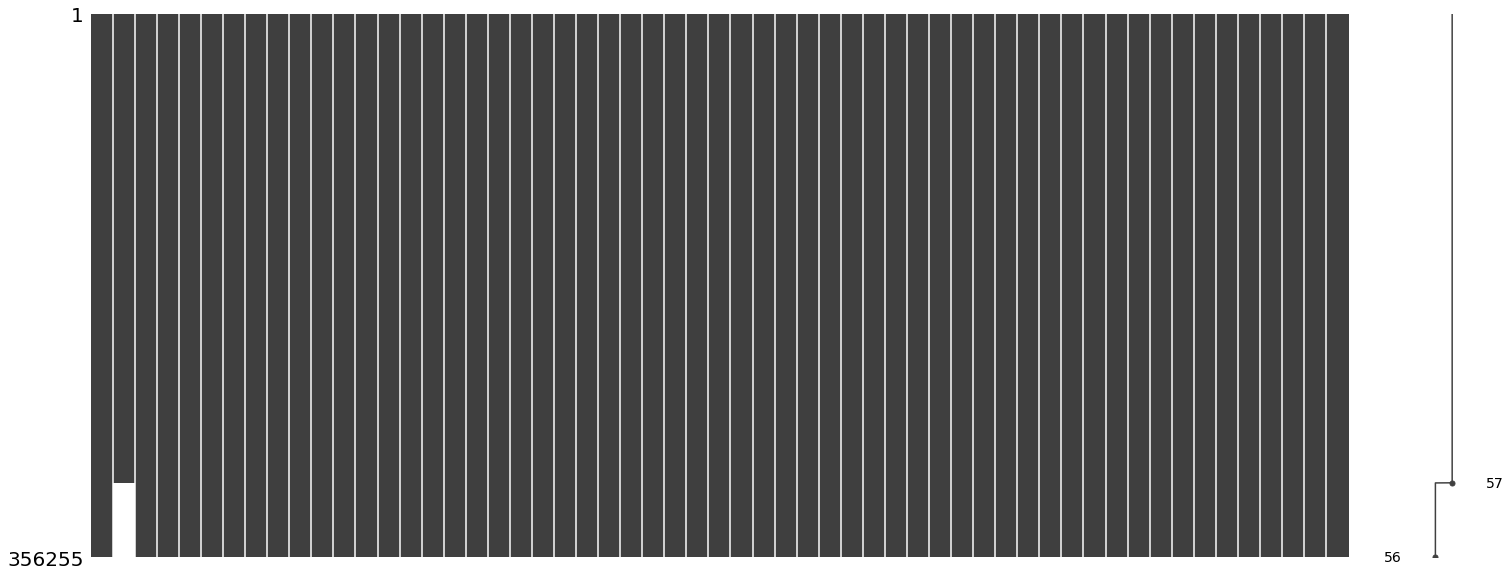

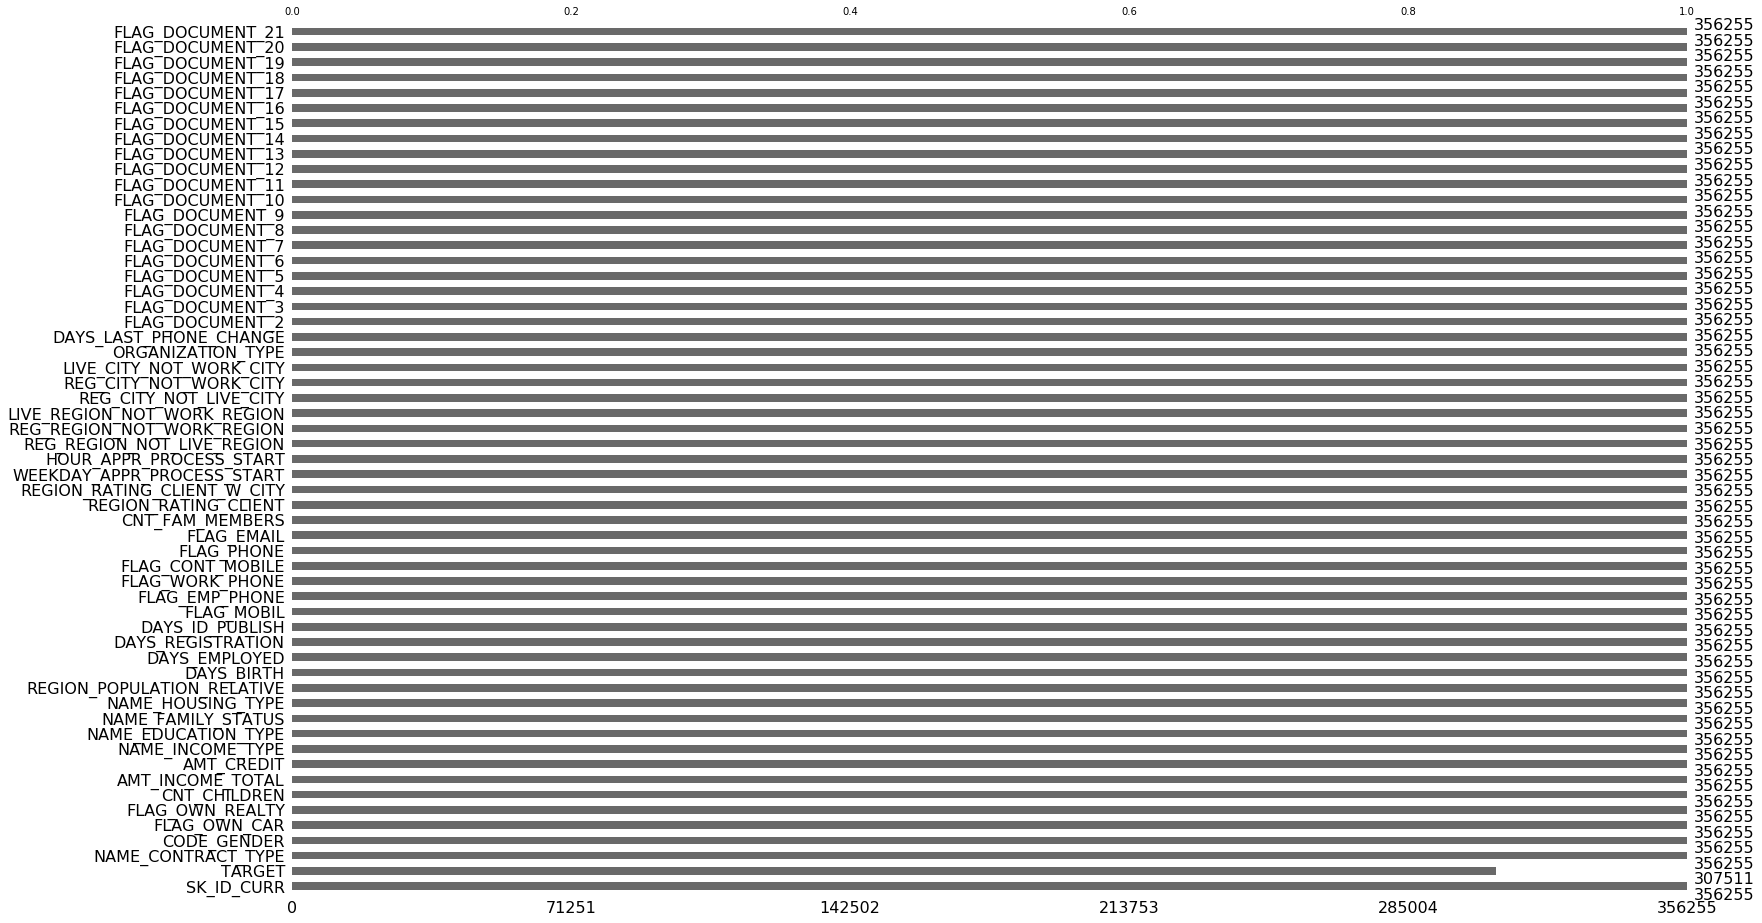

In [25]:
# 欠損値の状況を確認します。
import missingno as msno
display(msno.matrix(df))
plt.show()
display(msno.bar(df))
plt.show()

欠損値がなくなりました。

In [26]:
# one-hot encodingの要領でobjectのデータをintに変える。
df_dummy = pd.get_dummies(df)

In [27]:
df_dummy.info(145)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356255 entries, 0 to 356254
Data columns (total 146 columns):
 #    Column                                             Dtype  
---   ------                                             -----  
 0    SK_ID_CURR                                         float64
 1    TARGET                                             float64
 2    CNT_CHILDREN                                       float64
 3    AMT_INCOME_TOTAL                                   float64
 4    AMT_CREDIT                                         float64
 5    REGION_POPULATION_RELATIVE                         float64
 6    DAYS_BIRTH                                         float64
 7    DAYS_EMPLOYED                                      float64
 8    DAYS_REGISTRATION                                  float64
 9    DAYS_ID_PUBLISH                                    float64
 10   FLAG_MOBIL                                         float64
 11   FLAG_EMP_PHONE                       

### 評価①

In [28]:
# trainとtestにdfを分けます。
train = df_dummy[df_dummy['TARGET'].notnull()]
test  = df_dummy[df_dummy['TARGET'].isnull()]

In [29]:
# 説明変数のカラム取得
columns = list(train.columns)
columns.remove("TARGET")
columns
# 分割
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train.loc[:,columns], train["TARGET"], test_size=0.3,  random_state=0)

In [30]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [31]:
# xgboostを使うためimportする。
import xgboost as xgb

#特徴量と目的変数をxgboostのデータ構造に変換する。
dtrain = xgb.DMatrix(X_train, y_train) 
dtest = xgb.DMatrix(X_test, y_test)

# 学習用のパラメータを設定する。
params ={'objective': 'binary:logistic',# 二値分類問題
        'eval_metric': 'logloss',# 評価指標
        }

# モデルを学習する
model = xgb.train(params,
                  dtrain,
                  num_boost_round=50,# 学習ラウンド数は適当
                 )

# テストデータで推定
predictions = model.predict(dtest)

In [32]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions)

auc = metrics.auc(fpr, tpr)
auc

0.6764738096290916

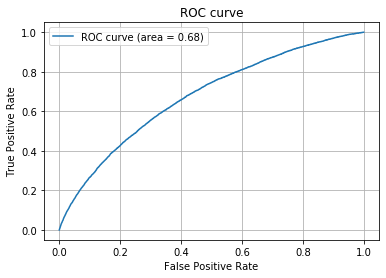

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

# ROC曲線をプロット
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

### 評価②

試しに相関の高いのだけ見てみる。

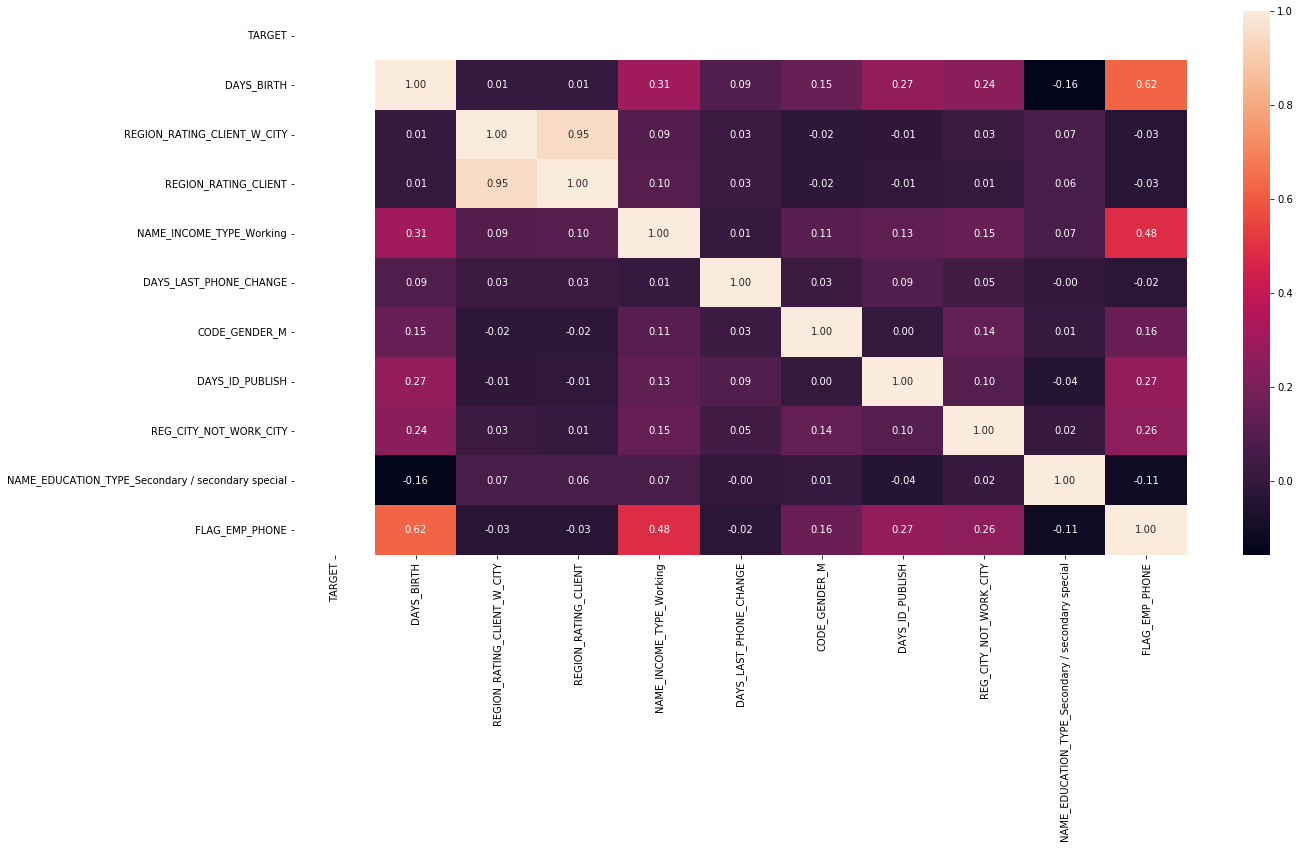

In [34]:
#相関係数行列のヒートマップを作り、相関係数の高い10項目を見つける。
corrmat = df_dummy.corr()
cols = corrmat.nlargest(11, 'TARGET')['TARGET'].index
cm = np.corrcoef(df_dummy[cols].values.T)
plt.figure(figsize=(20, 10))
sns.heatmap(cm,annot=True,fmt="1.2f",yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [35]:
df_dummy2 = df_dummy[cols]

In [36]:
# trainとtestにdfを分けます。
train = df_dummy2[df_dummy2['TARGET'].notnull()]
test  = df_dummy2[df_dummy2['TARGET'].isnull()]

In [37]:
# 説明変数のカラム取得
columns = list(train.columns)
columns.remove("TARGET")
columns
# 分割
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train.loc[:,columns], train["TARGET"], test_size=0.3,  random_state=0)

In [38]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [39]:
# xgboostを使うためimportする。
import xgboost as xgb

#特徴量と目的変数をxgboostのデータ構造に変換する。
dtrain = xgb.DMatrix(X_train, y_train) 
dtest = xgb.DMatrix(X_test, y_test)

# 学習用のパラメータを設定する。
params ={'objective': 'binary:logistic',# 二値分類問題
        'eval_metric': 'logloss',# 評価指標
        }

# モデルを学習する
model = xgb.train(params,
                  dtrain,
                  num_boost_round=50,# 学習ラウンド数は適当
                 )

# テストデータで推定
predictions = model.predict(dtest)

In [40]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions)

auc = metrics.auc(fpr, tpr)
auc

0.643598381218401

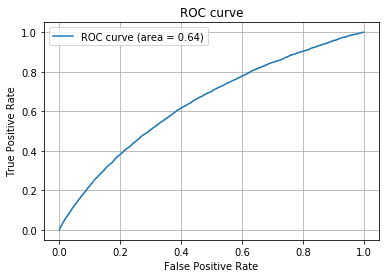

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

# ROC曲線をプロット
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

結果は悪くなった。

### 評価③
ランダムフォレストを使う。

In [42]:
# trainとtestにdfを分けます。
train = df_dummy[df_dummy['TARGET'].notnull()]
test  = df_dummy[df_dummy['TARGET'].isnull()]

In [43]:
# 説明変数のカラム取得
columns = list(train.columns)
columns.remove("TARGET")
columns
# 分割
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train.loc[:,columns], train["TARGET"], test_size=0.3,  random_state=0)

In [44]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [45]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

In [46]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions)

auc = metrics.auc(fpr, tpr)
auc

0.5

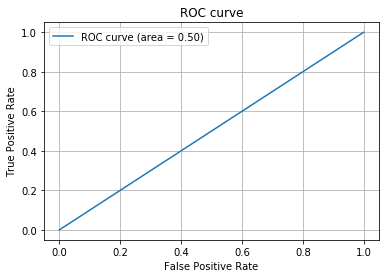

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline

# ROC曲線をプロット
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

より精度は落ちた。

### 評価④

欠損値の削除をしない。

In [48]:
# データをまた統合します。
df = pd.concat([application_train, application_test], ignore_index = True)

In [49]:
# dfに結合する
df = df.join([
    credit_card_balance_sum,
    previous_application_sum,
])

In [50]:
# one-hot encodingの要領でobjectのデータをintに変える。
df_dummy = pd.get_dummies(df)

In [51]:
# trainとtestにdfを分けます。
train = df_dummy[df_dummy['TARGET'].notnull()]
test  = df_dummy[df_dummy['TARGET'].isnull()]

In [52]:
# 説明変数のカラム取得
columns = list(train.columns)
columns.remove("TARGET")
columns
# 分割
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train.loc[:,columns], train["TARGET"], test_size=0.3,  random_state=0)

In [53]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [54]:
# xgboostを使うためimportする。
import xgboost as xgb

#特徴量と目的変数をxgboostのデータ構造に変換する。
dtrain = xgb.DMatrix(X_train, y_train) 
dtest = xgb.DMatrix(X_test, y_test)

# 学習用のパラメータを設定する。
params ={'objective': 'binary:logistic',# 二値分類問題
        'eval_metric': 'logloss',# 評価指標
        }

# モデルを学習する
model = xgb.train(params,
                  dtrain,
                  num_boost_round=50,# 学習ラウンド数は適当
                 )

# テストデータで推定
predictions = model.predict(dtest)

In [55]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions)

auc = metrics.auc(fpr, tpr)
auc

0.7539844793440312

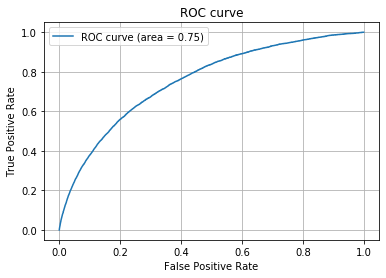

In [56]:
import matplotlib.pyplot as plt
%matplotlib inline

# ROC曲線をプロット
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

欠損値を削除しないのが一番いい！！

### 評価⑤

TARGETを2倍にする。

In [57]:
df[df.TARGET == 1.0]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,APPLICATION_RATE_INTEREST_PRIVILEGED,APPLICATION_DAYS_DECISION,APPLICATION_SELLERPLACE_AREA,APPLICATION_CNT_PAYMENT,APPLICATION_DAYS_FIRST_DRAWING,APPLICATION_DAYS_FIRST_DUE,APPLICATION_DAYS_LAST_DUE_1ST_VERSION,APPLICATION_DAYS_LAST_DUE,APPLICATION_DAYS_TERMINATION,APPLICATION_NFLAG_INSURED_ON_APPROVAL
0,100002.0,1.0,Cash loans,M,N,Y,0.0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,100031.0,1.0,Cash loans,F,N,Y,0.0,112500.0,979992.0,27076.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40,100047.0,1.0,Cash loans,M,N,Y,0.0,202500.0,1193580.0,35028.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42,100049.0,1.0,Cash loans,F,N,N,0.0,135000.0,288873.0,16258.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81,100096.0,1.0,Cash loans,F,N,Y,0.0,81000.0,252000.0,14593.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307448,456186.0,1.0,Cash loans,M,N,N,1.0,207000.0,450000.0,32746.5,...,0.715645,-3146.0,1550.0,12.0,362615.0,-3069.0,365094.0,-1062.0,364829.0,0.0
307475,456215.0,1.0,Cash loans,F,N,N,1.0,144000.0,1303200.0,46809.0,...,0.000000,-10105.0,3497.0,234.0,2188685.0,-9398.0,363784.0,-6289.0,-5023.0,3.0
307481,456225.0,1.0,Cash loans,M,N,Y,0.0,225000.0,297000.0,19975.5,...,0.000000,-2567.0,56.0,17.0,730486.0,-2445.0,-1995.0,362994.0,363641.0,0.0
307489,456233.0,1.0,Cash loans,F,N,Y,0.0,225000.0,521280.0,23089.5,...,0.000000,-5079.0,71.0,18.0,730486.0,-5013.0,-4533.0,-4533.0,-4521.0,1.0


In [58]:
df = df.append(df[df.TARGET == 1.0])

In [59]:
# one-hot encodingの要領でobjectのデータをintに変える。
df_dummy = pd.get_dummies(df)

In [60]:
# trainとtestにdfを分けます。
train = df_dummy[df_dummy['TARGET'].notnull()]
test  = df_dummy[df_dummy['TARGET'].isnull()]

In [61]:
# 説明変数のカラム取得
columns = list(train.columns)
columns.remove("TARGET")
columns
# 分割
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train.loc[:,columns], train["TARGET"], test_size=0.3,  random_state=0)

In [62]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [63]:
# xgboostを使うためimportする。
import xgboost as xgb

#特徴量と目的変数をxgboostのデータ構造に変換する。
dtrain = xgb.DMatrix(X_train, y_train) 
dtest = xgb.DMatrix(X_test, y_test)

# 学習用のパラメータを設定する。
params ={'objective': 'binary:logistic',# 二値分類問題
        'eval_metric': 'logloss',# 評価指標
        }

# モデルを学習する
model = xgb.train(params,
                  dtrain,
                  num_boost_round=50,# 学習ラウンド数は適当
                 )

# テストデータで推定
predictions = model.predict(dtest)

In [64]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions)

auc = metrics.auc(fpr, tpr)
auc

0.7833779458681163

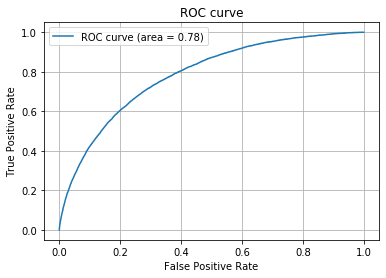

In [65]:
import matplotlib.pyplot as plt
%matplotlib inline

# ROC曲線をプロット
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

TARGET＝1を複製するともっといい！

### 学習と推定
欠損値削除せず、TARGET＝1を複製したデータを採用。

In [66]:
# trainとtestにdfを分けます。
train = df_dummy[df_dummy['TARGET'].notnull()]
test  = df_dummy[df_dummy['TARGET'].isnull()]

In [67]:
# DataFrameをndarrayへ変換する。
train = train.to_numpy()
test = test.to_numpy()

In [68]:
# 目的変数と説明変数に分ける。
X_train = train[:, 2:].astype(float) 
y_train = train[:, 1].astype(float) # 正解データ
X_test = test[:, 2:].astype(float) 

In [69]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [70]:
# xgboostを使うためimportする。
import xgboost as xgb

#特徴量と目的変数をxgboostのデータ構造に変換する。
dtrain = xgb.DMatrix(X_train, y_train) 
dtest = xgb.DMatrix(X_test)# y_testなくていい？ →これでよい。

# 学習用のパラメータを設定する。
params ={'objective': 'binary:logistic',# 二値分類問題
        'eval_metric': 'logloss',# 評価指標
        }

# モデルを学習する
model = xgb.train(params,
                  dtrain,
                  num_boost_round=50,# 学習ラウンド数は適当
                 )

# テストデータで推定
predictions = model.predict(dtest)

In [71]:
print(predictions)

[0.04269094 0.19549975 0.03546875 ... 0.04307111 0.07981717 0.26708823]


In [72]:
predictions = np.round(predictions, decimals=1)
predictions = np.where(predictions < 0, 0, predictions)

In [73]:
predictions

array([0. , 0.2, 0. , ..., 0. , 0.1, 0.3], dtype=float32)

## 【問題3】テストデータに対する推定
テストデータ（application_test.csv）に対して推定を行い、Kaggleに提出を行ってください。\
正しく提出が行えていれば、精度は低くても構いません。



In [74]:
submission = pd.DataFrame({"SK_ID_CURR": SK_ID_CURR, "TARGET": predictions})
submission.to_csv("submission.csv", index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
